In [4]:
# General Library Imports
import numpy as np

# Torch Imports
import torch
import torch.utils.data as data
from torch.utils.data import random_split
from torch.utils.tensorboard import SummaryWriter
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from  torch.distributions.multivariate_normal import MultivariateNormal

# Plotting Imports
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 5]

Create the training data: write a function that generates samples x of a 3D normal distribution. The corresponding desired-output data y are located on the unit sphere (surface of ball of radius 1) in the same direction as input x.

In [5]:
class GaussDataset(data.Dataset):
    def __init__(self, size) -> None:
        super().__init__()
        self.size = size
        # Attribute for the data
        self.data_generation()

    def data_generation(self):
        distrubution = MultivariateNormal(torch.zeros(3), torch.eye(3))
        X = distrubution.sample((self.size,))
        y = X.div(torch.linalg.norm(X, dim=1).reshape(-1, 1))
        self.X = X
        self.y = y

    def __len__(self):
        return self.size
    
    def __getitem__(self, index):
        return self.X[index], self.y[index]

dataset = GaussDataset(30000)

Split training, validation, and test data. Method: Define dataloaders after sample generation use random split for simplicity and easier control. However I state the seed for reproducibility

In [6]:
# Set the seed
seed = 555
np.random.seed(seed)
torch.manual_seed(seed)

# Initialise variables
dataset_size = len(dataset)
train_size = int(dataset_size * 0.6)
val_size = int(dataset_size * 0.2)
test_size = dataset_size - train_size - val_size

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Create the dataloaders
# Shuffles for improvement in generalisation, bias reduction and variance assurance
# Drop last batch incase of not fulfilling of batch size
train_loader = data.DataLoader(train_dataset, batch_size=300, drop_last=True, shuffle=True)
val_loader = data.DataLoader(val_dataset, batch_size=300, drop_last=True, shuffle=True)
test_loader = data.DataLoader(test_dataset, batch_size=300, drop_last=True, shuffle=True)

Create a 3D plot of the training data output on the sphere, and ensure 'correctness'

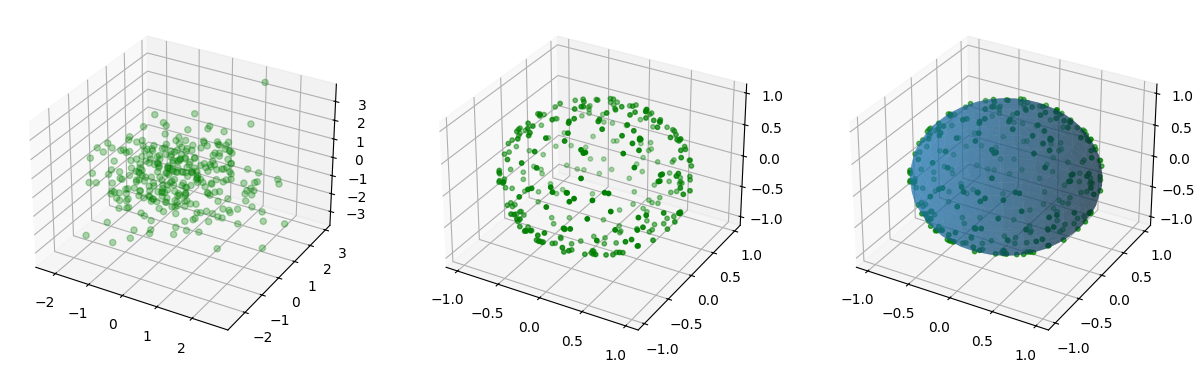

In [9]:
N = 15  # number of strides to draw the sphere
n_vis_sample = 500
up, vp = np.mgrid[0:2 * np.pi:30j, 0:np.pi:20j]
x = np.cos(up) * np.sin(vp)
y = np.sin(up) * np.sin(vp)
z = np.cos(vp)

fig, ax = plt.subplots(1, 3, subplot_kw={'projection': '3d'})

# Extract indices from train_dataset if it's a Subset
if isinstance(train_dataset, torch.utils.data.Subset):
    train_indices = train_dataset.indices
else:
    train_indices = list(range(len(train_dataset)))

# Ensure we don't exceed the number of available samples
n_vis_sample = min(n_vis_sample, len(train_indices))

vizX = dataset.X.cpu().numpy()[train_indices[:n_vis_sample]]
vizY = dataset.y.cpu().numpy()[train_indices[:n_vis_sample]]

# for plotting
ax[0].scatter(vizX[:, 0], vizX[:, 1], vizX[:, 2], alpha=0.3, c='g', marker='o')
ax[1].scatter(vizY[:, 0], vizY[:, 1], vizY[:, 2], s=10, c='g', marker='o')
ax[2].plot_surface(x, y, z, linewidth=0.0, alpha=0.5)
ax[2].scatter(vizY[:, 0], vizY[:, 1], vizY[:, 2], s=10, c='g', marker='o')

plt.show()

Create a neural network model (may use use libraries provided with the
language). Use four fully-connected layers that are 3 (input), 20, 20 and 3
(output) wide, and nonlinear activation for all but the last layer.

In [131]:
# Regression Model
class RegressionNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(3, 20)
        self.fc2 = nn.Linear(20, 20)
        self.fc3 = nn.Linear(20, 20)
        self.fc4 = nn.Linear(20, 3)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x
    
model = RegressionNN()
criterion = nn.MSELoss()
optimiser = optim.Adam(model.parameters())


Visualisation functions for plot comparisons, reviews, and average MSE 

In [132]:
# Visualise the regression model
@torch.no_grad()
def vis_regression(model, data_loader):
    model.eval()
    predictions = []
    with torch.no_grad():
        for X, y in data_loader:
            pred = model(X)
            predictions.append(pred)
    
    fig, axes = plt.subplots(1, 3, subplot_kw={'projection': '3d'})
    pred_dis = np.vstack([pred.cpu().numpy() for pred in predictions])
    
    for ax in axes:
        ax.scatter(pred_dis[:, 0], pred_dis[:, 1], pred_dis[:, 2], alpha=0.3, s=1, c='b', marker='o')
    
    plt.show()

# Visualise the model in a histogram
@torch.no_grad()
def vis_histograms(model, data_loader):
    predictions = []
    X_data = []
    model.eval()

    with torch.no_grad():
        for X, y in data_loader:
            pred = model(X)
            predictions.append(pred)
            X_data.append(X)

    fig, ax = plt.subplots(1, 1)
    out = np.linalg.norm(np.vstack([pred.cpu().numpy() for pred in predictions]), axis=1)
    out_x = np.linalg.norm(np.vstack([x.cpu().numpy() for x in X_data]), axis=1)

    ax.hist(out, bins=100, alpha=0.5, label='Predictions')
    ax.hist(out_x, bins=100, alpha=0.5, label='Original')
    return fig

# Calculate the average MSE
def avg_mse(model, data_loader):
    model.eval()
    mse = 0
    with torch.no_grad():
        for X, y in data_loader:
            pred = model(X)
            mse += torch.nn.functional.mse_loss(pred, y)
    return mse / len(data_loader.sampler)


Train the model with reasonable minibatch size, epoch number, database size,
initalization (that is, try some). Higher marks for method that shows gradient
expliclitly. (So do not, e.g., use fit() of tensorflow.) Verify with a reasonable measure that your system obtains good performance on
test data.


Epoch 1/200, loss: 0.004740313295688895


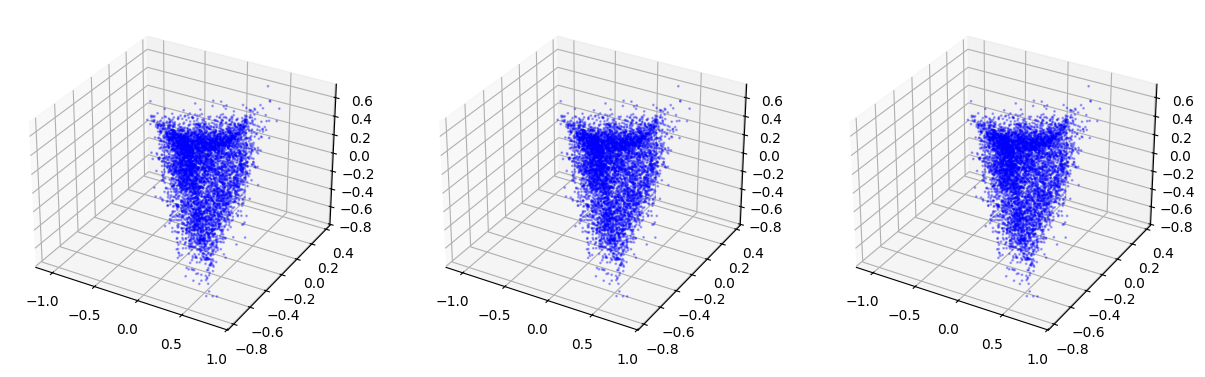

Epoch 2/200, loss: 0.001331851119114845
Epoch 3/200, loss: 0.0004437715977531237
Epoch 4/200, loss: 0.0003162318829917866
Epoch 5/200, loss: 0.0002301874204667682
Epoch 6/200, loss: 0.0001417515783334858
Epoch 7/200, loss: 8.506440578886583e-05
Epoch 8/200, loss: 5.950209070404527e-05
Epoch 9/200, loss: 4.947986117444493e-05
Epoch 10/200, loss: 4.358844668182967e-05
Epoch 11/200, loss: 3.95925518743752e-05
Epoch 12/200, loss: 3.6445743655586506e-05
Epoch 13/200, loss: 3.394694030335544e-05
Epoch 14/200, loss: 3.181367115219473e-05
Epoch 15/200, loss: 2.9962385640931273e-05
Epoch 16/200, loss: 2.8388155004267227e-05
Epoch 17/200, loss: 2.7007928748250748e-05
Epoch 18/200, loss: 2.5942998888818285e-05
Epoch 19/200, loss: 2.4829902066851865e-05
Epoch 20/200, loss: 2.3831128752569417e-05
Epoch 21/200, loss: 2.315448593452823e-05
Epoch 22/200, loss: 2.2363208119568297e-05
Epoch 23/200, loss: 2.162442493461573e-05
Epoch 24/200, loss: 2.093140973971997e-05
Epoch 25/200, loss: 2.03825882770319

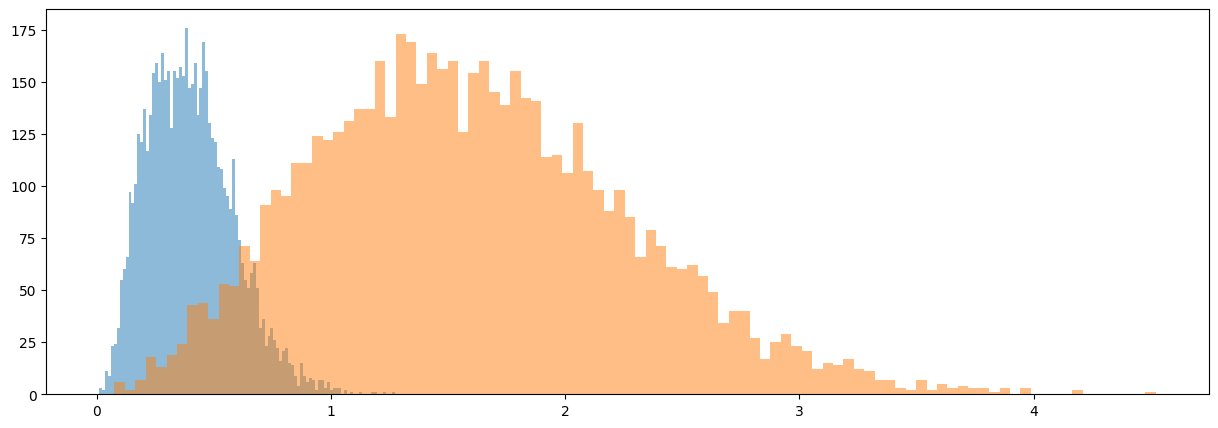

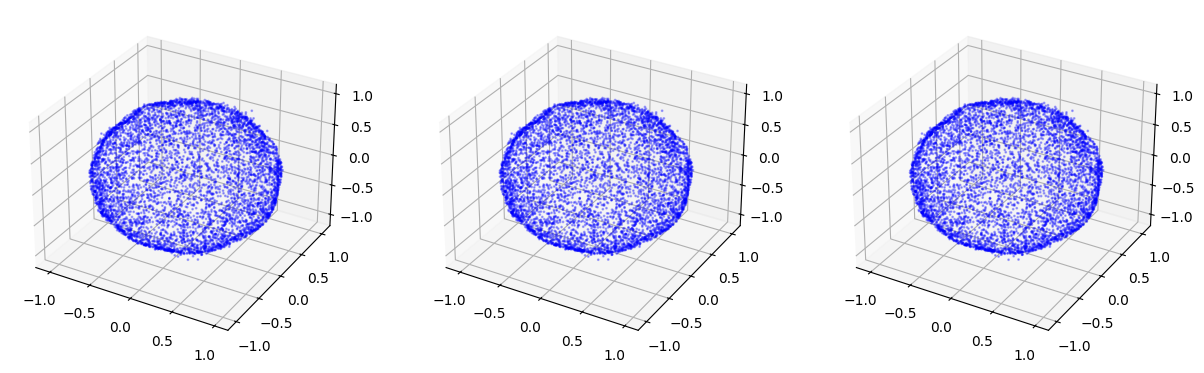

Epoch 52/200, loss: 1.3127066228391616e-05
Epoch 53/200, loss: 1.3106707471276792e-05
Epoch 54/200, loss: 1.2832648174252998e-05
Epoch 55/200, loss: 1.2733083851883378e-05
Epoch 56/200, loss: 1.2530289079276608e-05
Epoch 57/200, loss: 1.2497527082127312e-05
Epoch 58/200, loss: 1.2434085625292802e-05
Epoch 59/200, loss: 1.2323803183759014e-05
Epoch 60/200, loss: 1.208916771114875e-05
Epoch 61/200, loss: 1.206227584730961e-05
Epoch 62/200, loss: 1.1891350324569631e-05
Epoch 63/200, loss: 1.2019834172913558e-05
Epoch 64/200, loss: 1.1877912852486824e-05
Epoch 65/200, loss: 1.1777438298358229e-05
Epoch 66/200, loss: 1.1603566674101685e-05
Epoch 67/200, loss: 1.1470241847898621e-05
Epoch 68/200, loss: 1.1376912152155893e-05
Epoch 69/200, loss: 1.1439139901209542e-05
Epoch 70/200, loss: 1.1313509590389138e-05
Epoch 71/200, loss: 1.1160586077071289e-05
Epoch 72/200, loss: 1.1167740815963717e-05
Epoch 73/200, loss: 1.0999313283763412e-05
Epoch 74/200, loss: 1.0977368274276765e-05
Epoch 75/200,

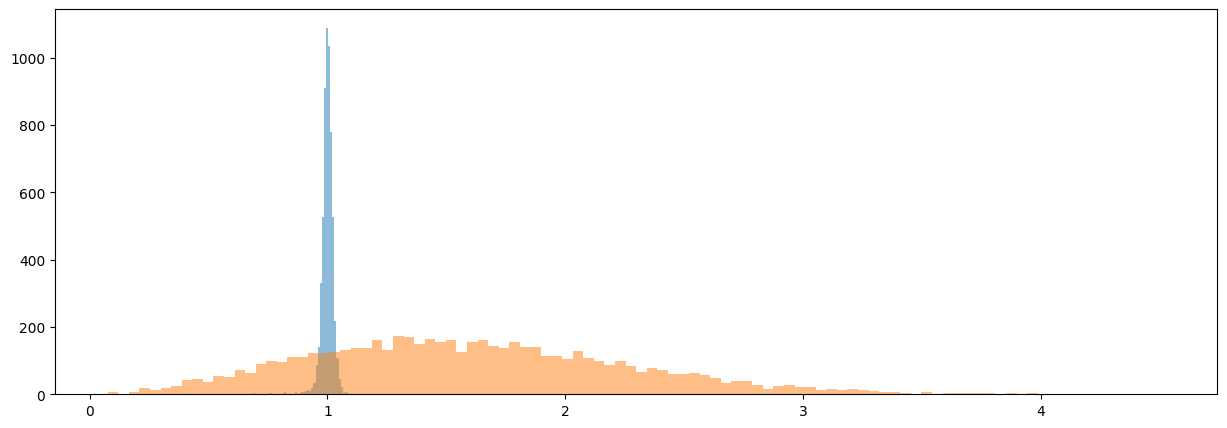

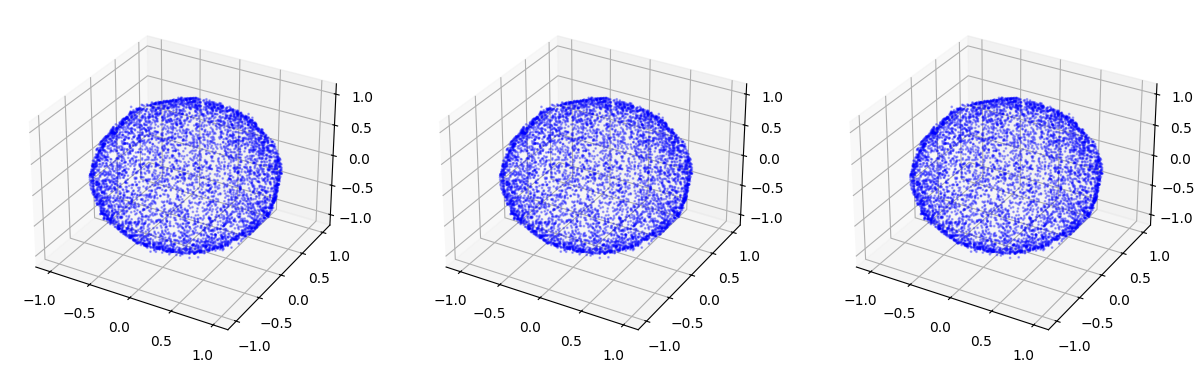

Epoch 102/200, loss: 9.600727678561169e-06
Epoch 103/200, loss: 9.525606651584019e-06
Epoch 104/200, loss: 9.417428095955444e-06
Epoch 105/200, loss: 9.485607127445055e-06
Epoch 106/200, loss: 9.449275948457028e-06
Epoch 107/200, loss: 9.357588439613917e-06
Epoch 108/200, loss: 9.217159985828738e-06
Epoch 109/200, loss: 9.303870033688359e-06
Epoch 110/200, loss: 9.342455522941976e-06
Epoch 111/200, loss: 9.185574299831557e-06
Epoch 112/200, loss: 9.433948942357718e-06
Epoch 113/200, loss: 9.172349074631508e-06
Epoch 114/200, loss: 9.09184598555132e-06
Epoch 115/200, loss: 9.096622361109809e-06
Epoch 116/200, loss: 9.093821935178614e-06
Epoch 117/200, loss: 9.033393952448494e-06
Epoch 118/200, loss: 9.073832471860644e-06
Epoch 119/200, loss: 8.912406978346957e-06
Epoch 120/200, loss: 8.867873294236942e-06
Epoch 121/200, loss: 8.860943749545927e-06
Epoch 122/200, loss: 8.828686417222747e-06
Epoch 123/200, loss: 8.8682787252347e-06
Epoch 124/200, loss: 8.864436838122384e-06
Epoch 125/200,

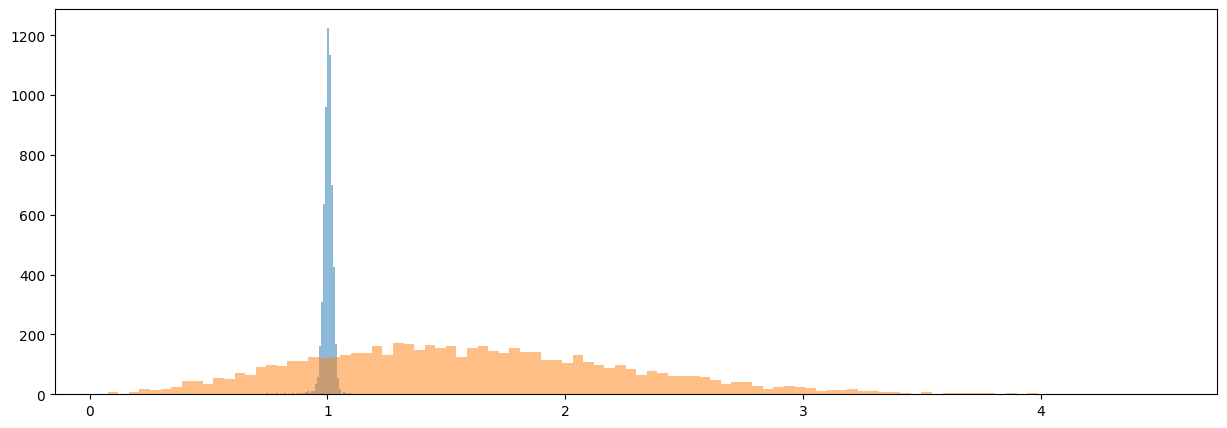

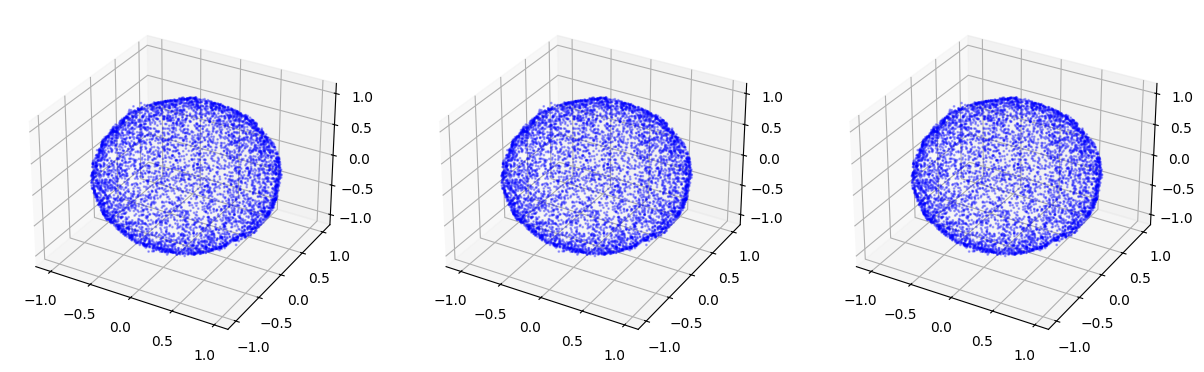

Epoch 152/200, loss: 8.236191434950376e-06
Epoch 153/200, loss: 8.039963415561674e-06
Epoch 154/200, loss: 8.025374422950673e-06
Epoch 155/200, loss: 8.059039376778485e-06
Epoch 156/200, loss: 8.023984985945086e-06
Epoch 157/200, loss: 8.044602456506658e-06
Epoch 158/200, loss: 7.99570303237016e-06
Epoch 159/200, loss: 8.043205616786846e-06
Epoch 160/200, loss: 7.953838917527282e-06
Epoch 161/200, loss: 7.96298418579816e-06
Epoch 162/200, loss: 8.072586519405443e-06
Epoch 163/200, loss: 7.900024327508518e-06
Epoch 164/200, loss: 7.932306697809879e-06
Epoch 165/200, loss: 7.978029130288094e-06
Epoch 166/200, loss: 7.92152018125543e-06
Epoch 167/200, loss: 7.877306978318504e-06
Epoch 168/200, loss: 7.805195754380191e-06
Epoch 169/200, loss: 7.763539246073008e-06
Epoch 170/200, loss: 7.843238980071705e-06
Epoch 171/200, loss: 7.834429852079698e-06
Epoch 172/200, loss: 7.704810989893707e-06
Epoch 173/200, loss: 7.67169462561907e-06
Epoch 174/200, loss: 7.755984436361931e-06
Epoch 175/200, 

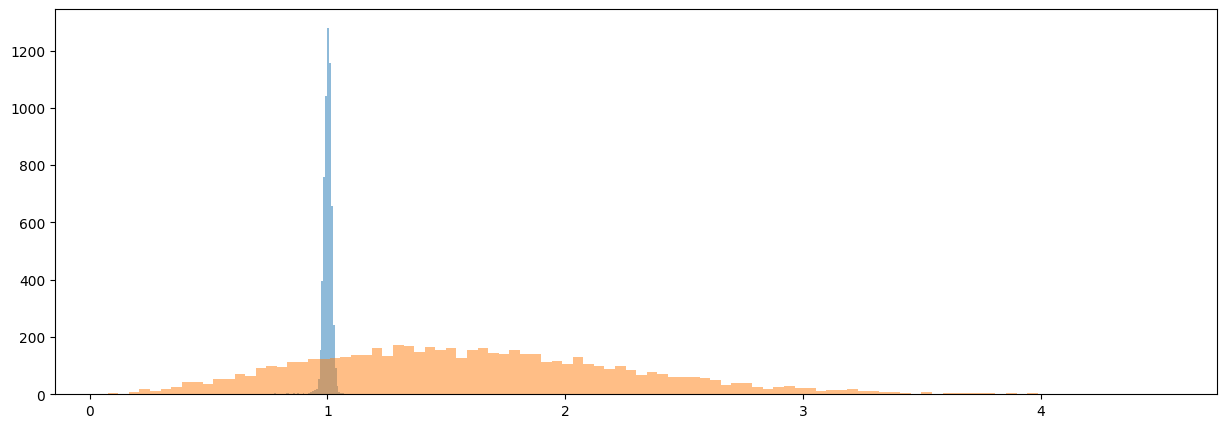

In [133]:
# variables for training
epochs = 200

# Training loop
def train_data(model, data_loader, val_loader, optimiser, criterion, epochs):

    train_loss = []
    val_loss = []
    epoch_loss = 0

    for epoch in range(epochs):
        model.train()
        for X, y in data_loader:
            
            pred = model(X)
            loss = criterion(pred, y)
            optimiser.zero_grad()

            loss.backward()
            optimiser.step()
            epoch_loss += loss.item() * y.shape[0]
        epoch_loss /= len(data_loader.sampler)
        train_loss.append(epoch_loss / len(train_loader))
        print(f"Epoch {epoch + 1}/{epochs}, loss: {epoch_loss / len(train_loader)}")

        model.eval()
        epoch_loss = 0
        with torch.no_grad():
            for X, y in val_loader:
                pred = model(X)
                loss = criterion(pred, y)
                epoch_loss += loss.item() * y.shape[0]
            epoch_loss /= len(val_loader.sampler)
            val_loss.append(epoch_loss / len(val_loader))

        # Visualize regression and histogram after each epoch
        if epoch % 50 == 0:
            vis_regression(model, val_loader)
            vis_histograms(model, val_loader)

    return train_loss, val_loss

train_loss, val_loss = train_data(model, train_loader, val_loader, optimiser, criterion, epochs)

Obtain training and validation performance as a function of epoch number

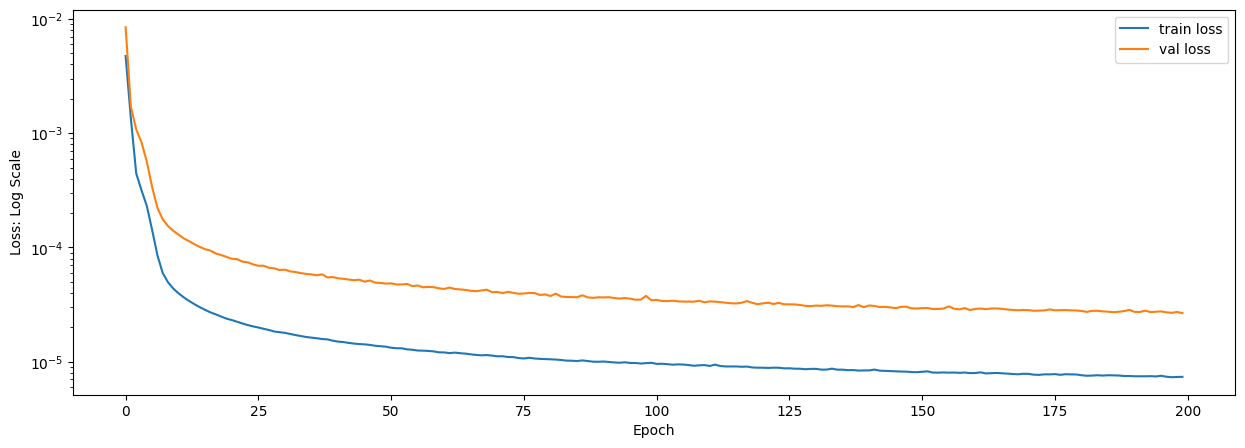

In [134]:
plt.plot(train_loss, label='train loss')
plt.plot(val_loss, label='val loss')
plt.yscale('log')  
plt.xlabel('Epoch')
plt.ylabel('Loss: Log Scale')
plt.legend(loc='upper right')
plt.show()

Full-Batch Model:

Epoch 1/200, loss: 0.005602609117825826


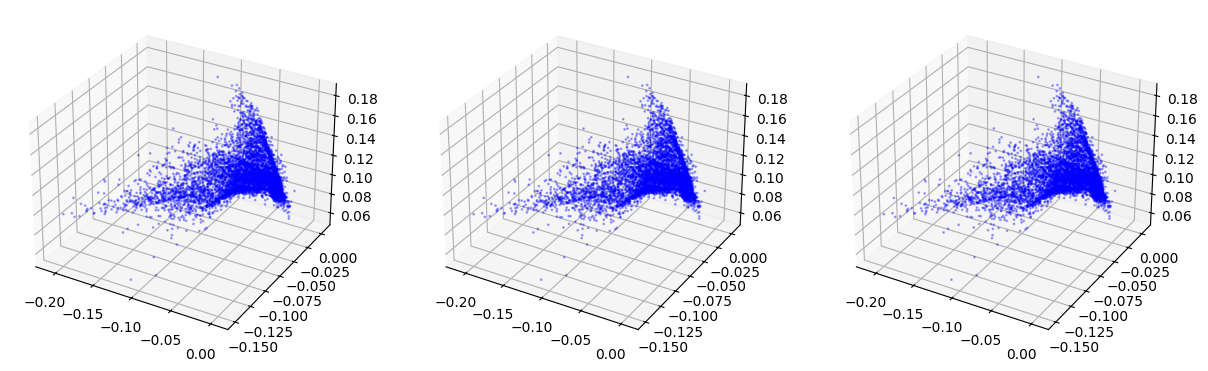

Epoch 2/200, loss: 0.005542189112167668
Epoch 3/200, loss: 0.005483732286744095
Epoch 4/200, loss: 0.00542679645879953
Epoch 5/200, loss: 0.005370268968423759
Epoch 6/200, loss: 0.005313762842091146
Epoch 7/200, loss: 0.00525621608412928
Epoch 8/200, loss: 0.005197580973679821
Epoch 9/200, loss: 0.005136726968473306
Epoch 10/200, loss: 0.005073473232418851
Epoch 11/200, loss: 0.005006580448040256
Epoch 12/200, loss: 0.004935710331024947
Epoch 13/200, loss: 0.0048602327770381065
Epoch 14/200, loss: 0.0047793783484785645
Epoch 15/200, loss: 0.004692887997917003
Epoch 16/200, loss: 0.004600425925616313
Epoch 17/200, loss: 0.004501554264956051
Epoch 18/200, loss: 0.0043958813323604845
Epoch 19/200, loss: 0.004282312851744118
Epoch 20/200, loss: 0.004160493887312435
Epoch 21/200, loss: 0.0040304442818793985
Epoch 22/200, loss: 0.003892198699147061
Epoch 23/200, loss: 0.003747389257430203
Epoch 24/200, loss: 0.0035969490789428903
Epoch 25/200, loss: 0.003442555134639972
Epoch 26/200, loss: 0

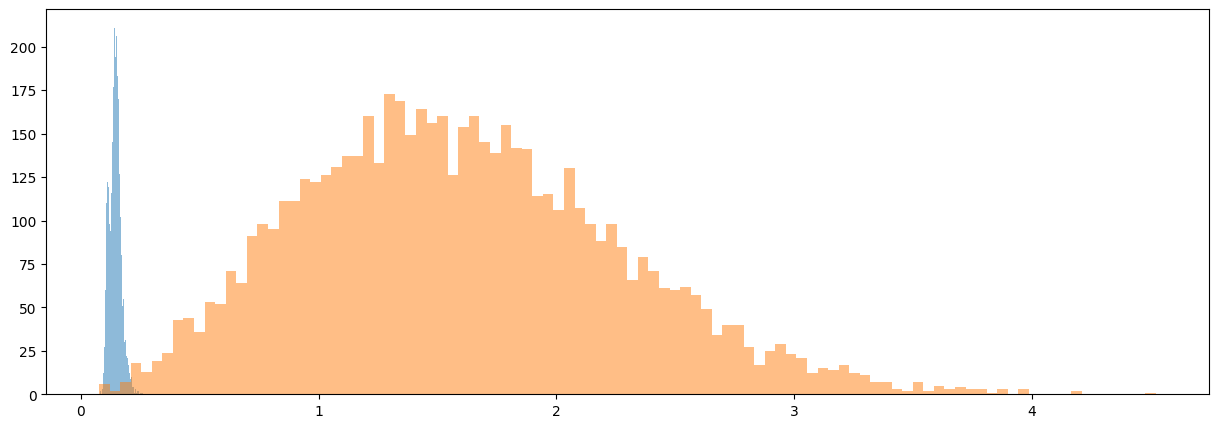

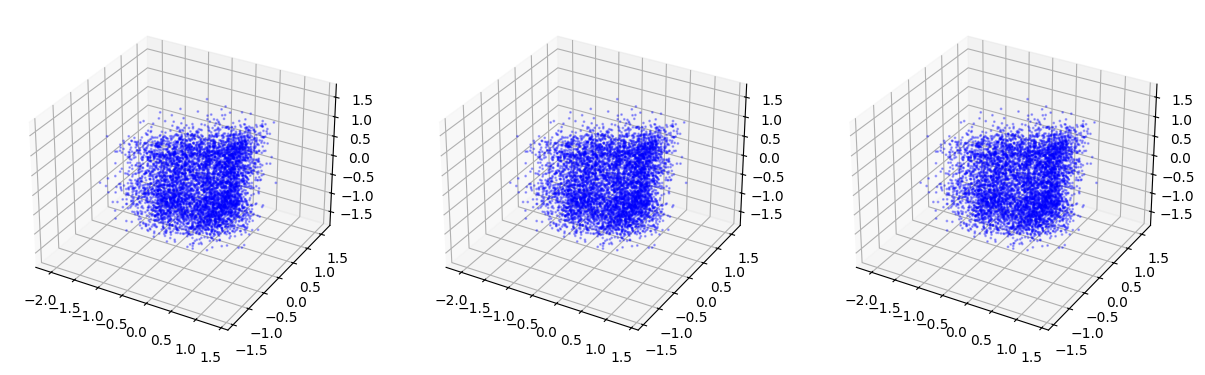

Epoch 52/200, loss: 0.0005481643506067081
Epoch 53/200, loss: 0.0005338106469872097
Epoch 54/200, loss: 0.0005197410269605892
Epoch 55/200, loss: 0.0005056649854855129
Epoch 56/200, loss: 0.0004920099629140976
Epoch 57/200, loss: 0.0004787052697001922
Epoch 58/200, loss: 0.0004662362767081639
Epoch 59/200, loss: 0.00045475982949655093
Epoch 60/200, loss: 0.0004443008915409101
Epoch 61/200, loss: 0.000434923011759572
Epoch 62/200, loss: 0.00042644395482881615
Epoch 63/200, loss: 0.00041874996876620034
Epoch 64/200, loss: 0.00041161962101770634
Epoch 65/200, loss: 0.00040486646587874187
Epoch 66/200, loss: 0.000398413242460056
Epoch 67/200, loss: 0.00039210823273062016
Epoch 68/200, loss: 0.0003858835535779319
Epoch 69/200, loss: 0.0003796445799620684
Epoch 70/200, loss: 0.0003735390854878696
Epoch 71/200, loss: 0.0003675499223586586
Epoch 72/200, loss: 0.00036177477082927474
Epoch 73/200, loss: 0.0003561704658506507
Epoch 74/200, loss: 0.00035078023716600404
Epoch 75/200, loss: 0.000345

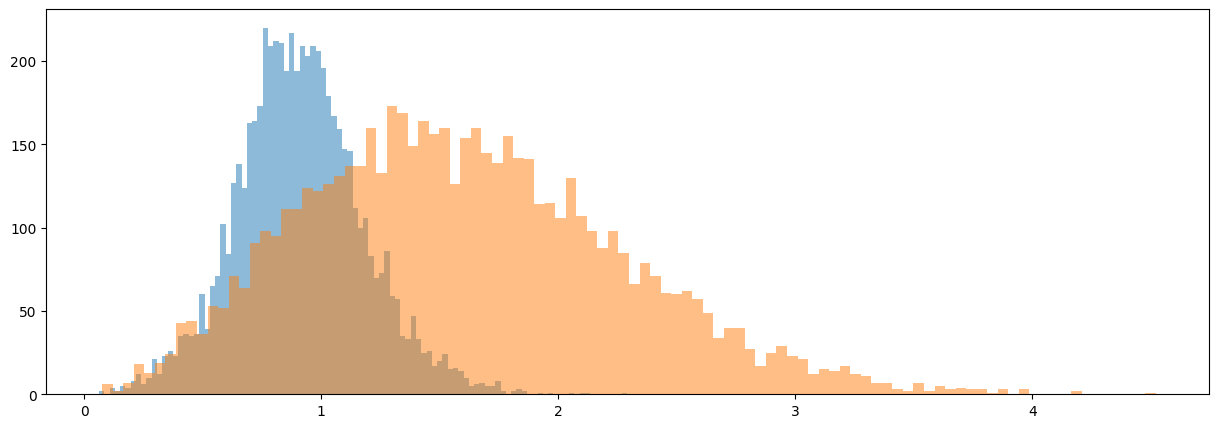

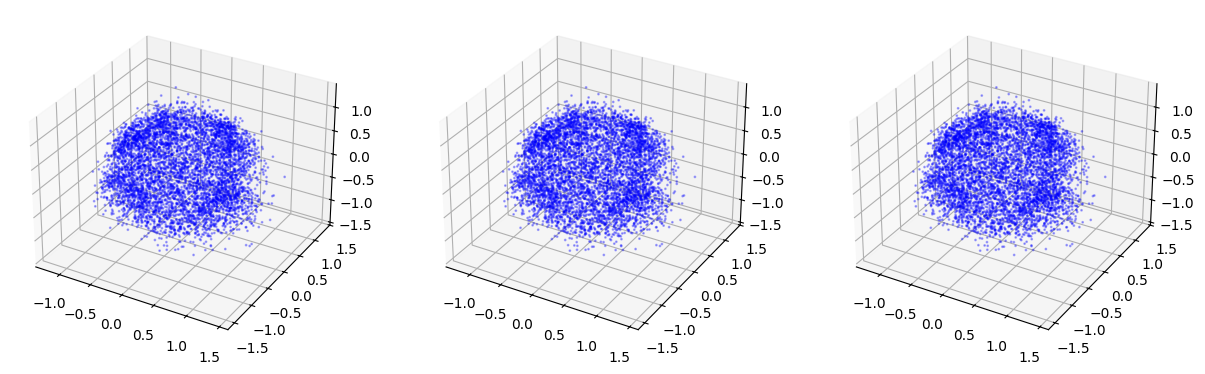

Epoch 102/200, loss: 0.00020776069777741753
Epoch 103/200, loss: 0.0002022872827352128
Epoch 104/200, loss: 0.00019686156127869187
Epoch 105/200, loss: 0.000191482742484314
Epoch 106/200, loss: 0.00018616812367906312
Epoch 107/200, loss: 0.00018088526556449426
Epoch 108/200, loss: 0.0001757264461639958
Epoch 109/200, loss: 0.00017062760275374684
Epoch 110/200, loss: 0.00016567250055053994
Epoch 111/200, loss: 0.00016085215126750645
Epoch 112/200, loss: 0.0001561482475617797
Epoch 113/200, loss: 0.00015157658244845354
Epoch 114/200, loss: 0.00014715659711208125
Epoch 115/200, loss: 0.0001428888665326802
Epoch 116/200, loss: 0.00013873722608873828
Epoch 117/200, loss: 0.00013473930970153393
Epoch 118/200, loss: 0.0001308882631206264
Epoch 119/200, loss: 0.00012720869333241824
Epoch 120/200, loss: 0.0001236837111639842
Epoch 121/200, loss: 0.00012031079453472221
Epoch 122/200, loss: 0.00011708261848586889
Epoch 123/200, loss: 0.00011401223955822557
Epoch 124/200, loss: 0.00011107922995967

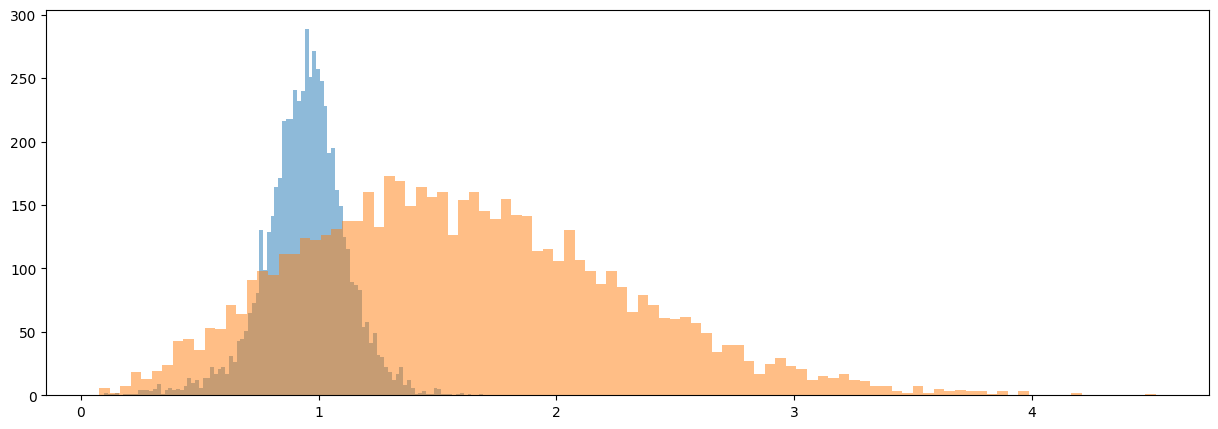

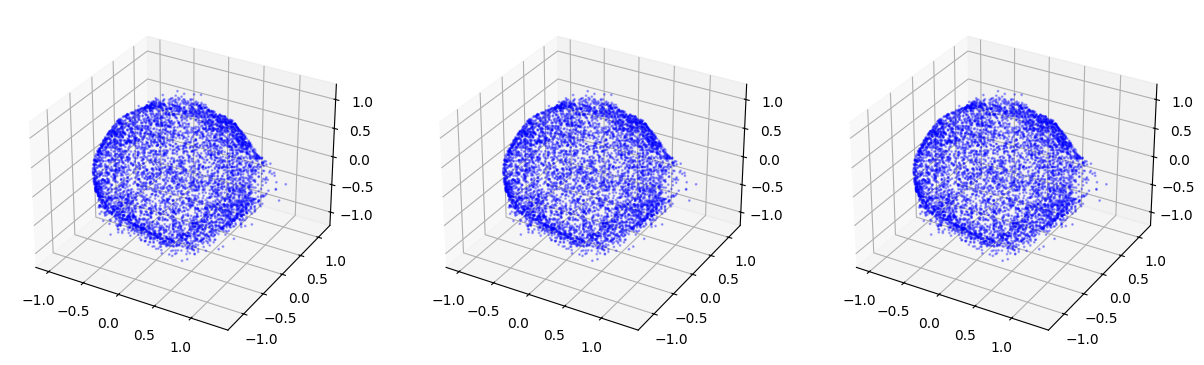

Epoch 152/200, loss: 6.669788114700673e-05
Epoch 153/200, loss: 6.578728585327216e-05
Epoch 154/200, loss: 6.491535858604712e-05
Epoch 155/200, loss: 6.406194800748144e-05
Epoch 156/200, loss: 6.323715808189094e-05
Epoch 157/200, loss: 6.24362196419733e-05
Epoch 158/200, loss: 6.166443318253624e-05
Epoch 159/200, loss: 6.091011140055747e-05
Epoch 160/200, loss: 6.017744274706476e-05
Epoch 161/200, loss: 5.9466388691820344e-05
Epoch 162/200, loss: 5.878316399455933e-05
Epoch 163/200, loss: 5.812528813775215e-05
Epoch 164/200, loss: 5.748643408167279e-05
Epoch 165/200, loss: 5.68790716703343e-05
Epoch 166/200, loss: 5.626581870396707e-05
Epoch 167/200, loss: 5.5688122346139234e-05
Epoch 168/200, loss: 5.5129450953272344e-05
Epoch 169/200, loss: 5.458564083264381e-05
Epoch 170/200, loss: 5.4050581980522516e-05
Epoch 171/200, loss: 5.3540575041659864e-05
Epoch 172/200, loss: 5.304133375024389e-05
Epoch 173/200, loss: 5.2551271595897294e-05
Epoch 174/200, loss: 5.2079860456891496e-05
Epoch 

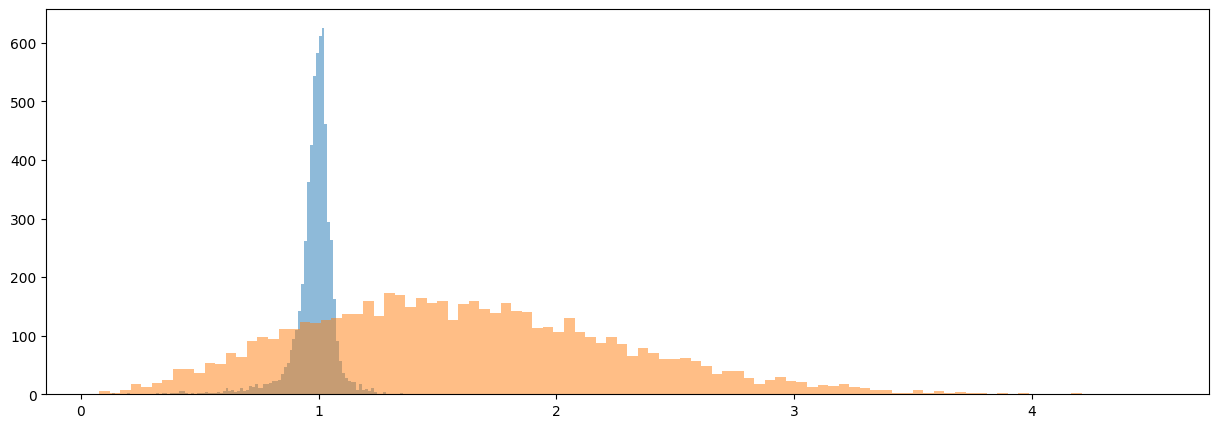

In [135]:
dataset_half_batch = GaussDataset(30000)

model_half_batch = RegressionNN()
criterion = nn.MSELoss()
optimiser = optim.Adam(model_half_batch.parameters())

full_train_loader = data.DataLoader(train_dataset, batch_size=int(len(train_dataset)/2), shuffle=True)
full_val_loader = data.DataLoader(val_dataset, batch_size=int(len(val_dataset)/2), shuffle=True)
full_test_loader = data.DataLoader(test_dataset, batch_size=int(len(test_dataset)/2), shuffle=True)

train_loss, val_loss = train_data(model_half_batch, full_train_loader, full_val_loader, optimiser, criterion, epochs)

Line Graph

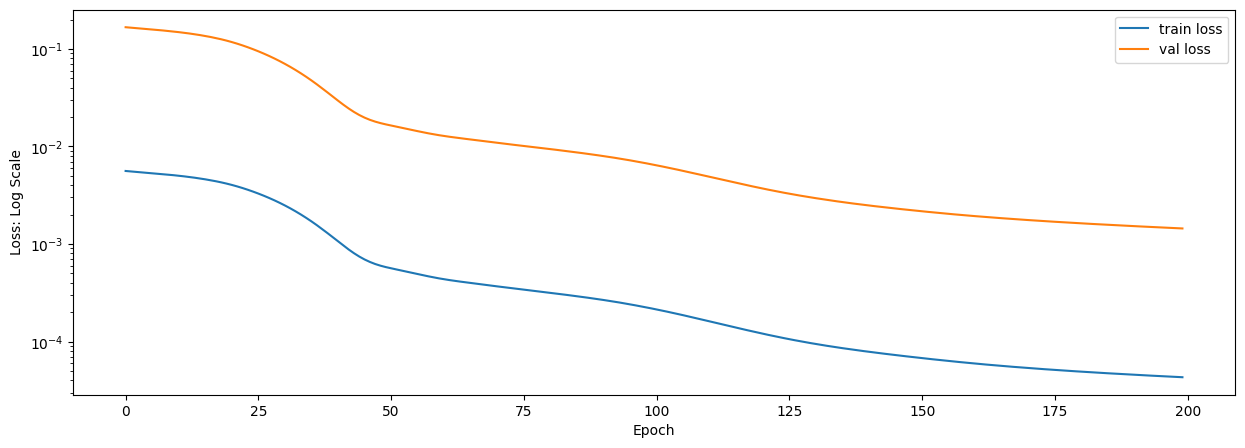

In [136]:
plt.plot(train_loss, label='train loss')
plt.plot(val_loss, label='val loss')
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss: Log Scale')
plt.legend(loc='upper right')
plt.show()